**We first load the dataset**

In [1]:
import numpy as np

data_path = "subdata.npy" # make sure npy file is under the same directory
d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)

**Visualizing the dataset in the first timesnap**

In [ ]:
# import libraries for plotting isosurfaces
import plotly
import plotly.graph_objs as go
# utility for clearing output of cell as loop runs in notebook
from IPython.display import clear_output

# plot the data in time 

L = 10; # length of spatial domain (cube of side L = 2*10)
N_grid = 64; # number of grid points/Fourier modes in each direction
xx = np.linspace(-L, L, N_grid+1) #spatial grid in x dir
x = xx[0:N_grid]
y = x # same grid in y direction
z = x # same grid in z direction

K_grid = (2*np.pi/(2*L))*np.linspace(-N_grid/2, N_grid/2 -1, N_grid) # frequency grid for each coordinate

xv, yv, zv = np.meshgrid( x, y, z) # generate 3D meshgrid in spatial domain

# plot iso surfaces in the first timesnap, change the end value to see more timesnaps
for j in range(0,1,3):

  signal = np.reshape(d[:, j], (N_grid, N_grid, N_grid)) # reshape the jth column
  normal_sig_abs = np.abs(signal)/np.abs(signal).max() # normalize the data

  # generate data for isosurface of the 3D data 
  fig_data = go.Isosurface( x = xv.flatten(), y = yv.flatten(), z = zv.flatten(),
                           value = normal_sig_abs.flatten(), isomin=0.7, isomax=0.7)

  # generate plots
  clear_output(wait=True) # need this to discard previous figs
  fig = go.Figure( data = fig_data )
  fig.show()


**Find the average of Fourior transformation**

In [3]:
ave_fft = np.zeros((64,64,64))
for j in range(49):
    d_hat = np.fft.fftn(np.reshape(d[:, j], (64, 64, 64)))
    d_hat = np.fft.fftshift(d_hat)
    ave_fft = ave_fft + d_hat

ave_fft = ave_fft/49 # we have 49 timesnaps in total

# get the spatial coordinate of the submarine
idx = np.argmax(np.abs(ave_fft))
idc = np.unravel_index(idx,(64,64,64)) # unflaten the index of center frequency
print("The spatial coordinates are ",x[idc[0]],y[idc[1]],z[idc[2]])

kx,ky,kz = np.meshgrid(K_grid,K_grid,K_grid)# frequency grid 
# get the center frequency
print("The center frequency is ",kx[idc],ky[idc],kz[idc])

The spatial coordinates are  2.1875 5.3125 -6.875
The center frequency is  5.340707511102648 2.199114857512855 -6.911503837897545


**Visualize the center frequency**

In [ ]:
normal_ave_fft = np.abs(ave_fft)/np.real(np.max((ave_fft)))
fig_data = go.Isosurface( x = kx.flatten(), y = ky.flatten(), z = kz.flatten(),
                           value = normal_ave_fft.flatten(), isomin=0.5, isomax=1)

fig = go.Figure( data = fig_data )
fig.show()

**We first track the data without filter. This is done by taking the coordinate with the greatest pressure and repeat for each timesnape to get 49 pairs of coordinates.**

**Clearly we could see there are outliers**

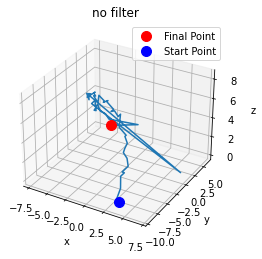

In [7]:
import matplotlib.pyplot as plt
import numpy as np

xc = []
yc = []
zc = []

for i in range(49):
    temp = np.reshape(d[:, i], (64, 64, 64))
    idx = np.argmax(temp)
    id2 = np.unravel_index(idx, (64, 64, 64))

    xc.append(xv[id2])
    yc.append(yv[id2])
    zc.append(zv[id2])

ax = plt.axes(projection='3d');
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.plot(xc, yc, zc,'-');
plt.plot(xc[-1], yc[-1], zc[-1],
        'ro', markersize=10, label='Final Point');
plt.plot(xc[0], yc[0], zc[0],
        'bo', markersize=10, label='Start Point');
#ax.view_init(15,60);
ax.set_title("no filter");
plt.legend();

**This time we apply a 3D Gaussion filter to the fourior transformation of data in each time snap**

In [8]:
def Gaussian(x,y,z,s):
    return np.exp( - ( ((x-kx[idc])**2 + (y-ky[idc])**2 + (z-kz[idc])**2))/(2*s**2))

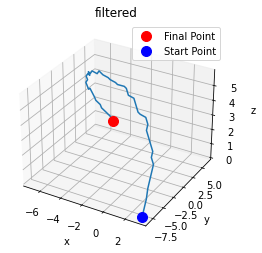

In [9]:
k_grid = np.linspace(-10, 10, 64)
k1, k2, k3 = np.meshgrid(K_grid, K_grid,K_grid)
sigma = 2
g_vals = Gaussian(k1, k2,k3, sigma)

xc = []
yc = []
zc = []
for i in range(49):
    d_hat = np.fft.fftn(np.reshape(d[:, i], (64, 64, 64)))
    d_hat = np.fft.fftshift(d_hat)
    d_hat_filtered = g_vals*d_hat
    d_filtered = np.abs(np.fft.ifftn(np.fft.ifftshift(d_hat_filtered)))
    
    idx = np.argmax(d_filtered)
    id = np.unravel_index(idx,(64,64,64))
    
    
    xc.append(xv[id])
    yc.append(yv[id])
    zc.append(zv[id])

ax = plt.axes(projection='3d')


ax.plot(xc, yc, zc,'-');
plt.plot(xc[-1], yc[-1], zc[-1],
        'ro', markersize=10, label='Final Point')
plt.plot(xc[0], yc[0], zc[0],
        'bo', markersize=10, label='Start Point')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.autoscale();
#ax.view_init(100,60);
ax.set_title("filtered");
plt.legend()
plt.show()

In [ ]:
value = np.zeros((64,64,64))
for i in range(49):
    value[int(np.where(x == xc[i])[0])][int(np.where(y == yc[i])[0])][int(np.where(z == zc[i])[0])] = 1

fig_data = go.Isosurface( x = xv.flatten(), y = yv.flatten(), z = zv.flatten(),
                           value = value.flatten(), isomin=0.01, isomax=1)

fig = go.Figure( data = fig_data )
fig.show()

The end location of the submarine is ( -5.3125 , 6.25 )


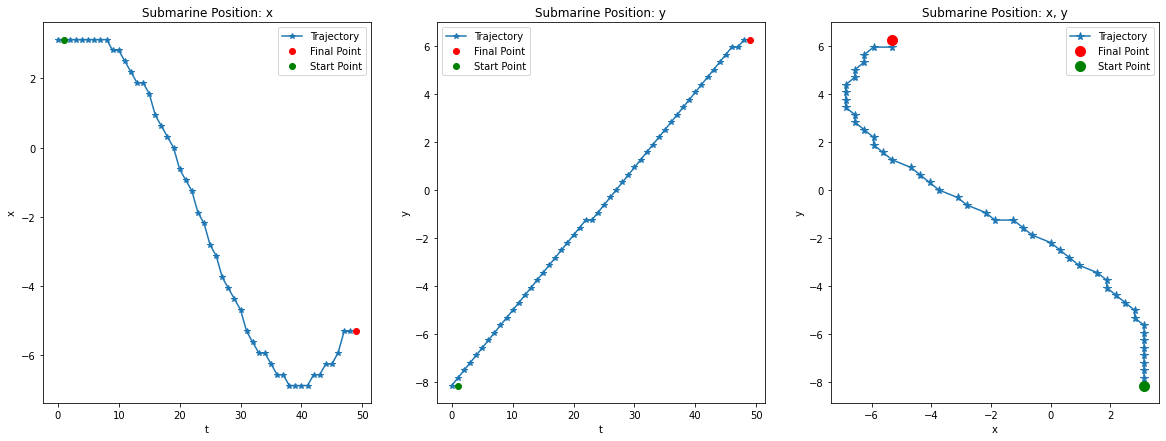

In [18]:
# 2D Projections
fig = plt.figure(figsize=(20, 7));

# x position
plt.subplot(1,3,1);
plt.plot(xc,'-*',label = 'Trajectory');
plt.plot(49,xc[-1],'ro',label='Final Point');
plt.plot(1,xc[0],'go',label='Start Point');
plt.xlabel('t'); plt.ylabel('x');
plt.title('Submarine Position: x');
plt.legend();

#y position
plt.subplot(1,3,2);
plt.plot(yc,'-*',label = 'Trajectory');
plt.plot(49,yc[-1],'ro',label='Final Point');
plt.plot(1,yc[0],'go',label='Start Point');
plt.xlabel('t'); plt.ylabel('y');
plt.title('Submarine Position: y');
plt.legend();


# x, y position
plt.subplot(1,3,3);
plt.plot(xc, yc, '-*', label='Trajectory', markersize=8);
plt.plot(xc[-1], yc[-1], 'ro',label='Final Point', markersize=10);
plt.plot(xc[0], yc[0], 'go',label='Start Point', markersize=10);
plt.xlabel('x'); plt.ylabel('y');
plt.title('Submarine Position: x, y');
plt.legend();

print("The end location of the submarine is (",xc[-1],",",yc[-1],")")